<a href="https://colab.research.google.com/github/tortor04/229352-StatisticalLearning/blob/main/lab10_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#660510741 ธัญพิสิษฐ์ ณ คำ

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #10

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision # For utils.make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from PIL import Image
from tqdm.auto import tqdm # For nice progress bars
from sklearn.metrics import accuracy_score

# Set device to GPU if available, else CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


We will use a dataset of pizza, stead and sushi images ([source](https://donlapark.pages.dev/229352/pizza_steak_sushi.zip))

In [4]:
!unzip -q pizza_steak_sushi.zip

# Data augmentation

![augmentation](https://miro.medium.com/max/700/0*LR1ZQucYW96prDte)

See more transformations in [Pytorch documentation](https://docs.pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended)

Class names: ['pizza', 'steak', 'sushi']
Class to index mapping: {'pizza': 0, 'steak': 1, 'sushi': 2}
Number of training samples: 225
Number of testing samples: 75
Number of batches in training DataLoader: 8
Number of batches in testing DataLoader: 1


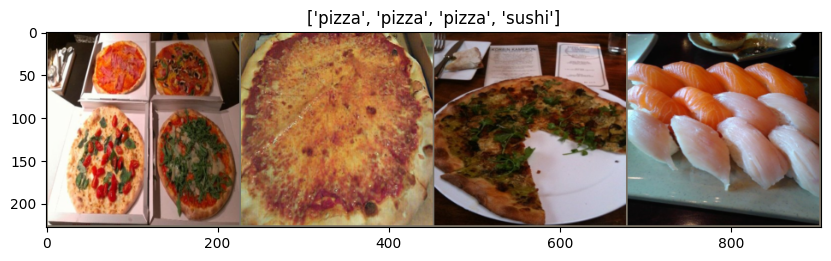

In [5]:
# 1. Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Resize all images to 224x224
    transforms.ToTensor(),         # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalize pixel values (ImageNet statistics)
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(0.4)
])

# 2. Create datasets using ImageFolder
train_data = datasets.ImageFolder(root="train",
                                  transform=data_transforms) # Write your code here
test_data = datasets.ImageFolder(root="test",
                                 transform=data_transforms) # Write your code here

# Get class names and their mapping
class_names = train_data.classes
class_to_idx = train_data.class_to_idx

print(f"Class names: {class_names}")
print(f"Class to index mapping: {class_to_idx}")
print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")

# 3. Create DataLoaders
BATCH_SIZE = 32 # You can experiment with different batch sizes

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)  # Write your code here

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=len(test_data),
                             shuffle=False)  # Write your code here

print(f"Number of batches in training DataLoader: {len(train_dataloader)}")
print(f"Number of batches in testing DataLoader: {len(test_dataloader)}")

# Let's visualize a sample image and its label
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # Convert from (C, H, W) to (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Undo normalization
    inp = np.clip(inp, 0, 1) # Clip pixel values to [0, 1]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4]) # Show first 4 images

plt.figure(figsize=(10, 5))
imshow(out, title=[class_names[x] for x in classes[:4]])
plt.show()

## Part 1: Implement and Train LeNet

LeNet-5 is one of the earliest convolutional neural networks, developed by Yann LeCun et al. in the 1990s. While originally designed for smaller images (like MNIST digits), we will adapt its architecture for our 224x224 pixel images.

![lenet5](http://d2l.ai/_images/lenet.svg)

### LeNet Architecture (Adapted for 224x224 input, 3 output classes):

1.  **Input Layer**: 3x224x224 image (RGB channels).
2.  **Conv1**: ([Conv2d document](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html))
    *   Input Channels: 3
    *   Output Channels: 6
    *   Kernel Size: 5x5
    *   Stride: 1
    *   Activation: ReLU
3.  **Pool1**: ([MaxPool2d document](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html))
    *   Type: Max Pooling
    *   Kernel Size: 2x2
    *   Stride: 2
4.  **Conv2**:
    *   Input Channels: 6
    *   Output Channels: 16
    *   Kernel Size: 5x5
    *   Stride: 1
    *   Activation: ReLU
5.  **Pool2**:
    *   Type: Max Pooling
    *   Kernel Size: 2x2
    *   Stride: 2
6.  **Flatten**: Flatten the 3D feature maps into a 1D vector.
    *   *Hint*: After Pool2, the feature map size will be `16 * (something) * (something)`. You'll need to calculate this dimension based on the input size and the conv/pool operations.
        *   Input (224x224) -> Conv1 (224-5+1 = 220x220)
        *   Pool1 (220/2 = 110x110)
        *   Conv2 (110-5+1 = 106x106)
        *   Pool2 (106/2 = 53x53)
        *   So, the output of Pool2 will be `16 * 53 * 53`.
7.  **FC1 (Fully Connected 1)**:
    *   Input Features: `16 * 53 * 53`
    *   Output Features: 120
    *   Activation: ReLU
8.  **FC2 (Fully Connected 2)**:
    *   Input Features: 120
    *   Output Features: 84
    *   Activation: ReLU
9.  **Output Layer (FC3)**:
    *   Input Features: 84
    *   Output Features: 3 (for pizza, steak, sushi)

**Your Task:**
1.  Implement the `LeNet` class following the architecture above.
2.  Instantiate the model and move it to the `device` (GPU/CPU).
3.  Define the loss function (`nn.CrossEntropyLoss`) and optimizer (`optim.Adam`).
4.  Train the LeNet model for a few epochs (e.g., 5-10).
5.  Evaluate its performance on the test set.

In [6]:
class LeNet(nn.Module):
    def __init__(self, num_classes=3):
        super(LeNet, self).__init__()
        # Write your code here
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2),  # output 6x224x224
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),                # 6x112x112
            nn.Conv2d(6, 16, kernel_size=5),                      # 16x108x108
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),                # 16x54x54
            nn.Conv2d(16, 120, kernel_size=5),                    # 120x50x50
            nn.Tanh(),
            nn.AdaptiveAvgPool2d((1,1)),                          # 120x1x1
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        # Write your code here
        x = self.features(x)
        x = self.classifier(x)
        return x

In [7]:
lenet_model = LeNet(num_classes=3).to(device)

lenet_model

LeNet(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Tanh()
    (3): Linear(in_features=84, out_features=3, bias=True)
  )
)

In [8]:

# Training loop function (to be reused)
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    print(f"\n--- Training {model.__class__.__name__} for {num_epochs} epochs ---")
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    model = model.to(device)
    for epoch in range(num_epochs):
        # Training phase
        model.train() # Set model to training mode
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_dataloader:
            # 1. Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 2. Zero the parameter gradients
            optimizer.zero_grad()

            # 3. Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 4. Backward + optimize only if in training phase
            loss.backward()
            optimizer.step()

            # 5. Statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        epoch_train_loss = train_loss / len(train_dataloader.dataset)
        epoch_train_acc = train_correct / train_total
        results["train_loss"].append(epoch_train_loss)
        results["train_acc"].append(epoch_train_acc)

        # Evaluation phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        epoch_test_loss = test_loss / len(test_dataloader.dataset)
        epoch_test_acc = test_correct / test_total
        results["test_loss"].append(epoch_test_loss)
        results["test_acc"].append(epoch_test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.4f}")
    return results


In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters(), lr=0.001)

In [10]:
# Train the LeNet model
lenet_results = train_model(lenet_model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=10)


--- Training LeNet for 10 epochs ---
Epoch 1/10 - Train Loss: 1.0669, Train Acc: 0.3867 | Test Loss: 1.1635, Test Acc: 0.2933
Epoch 2/10 - Train Loss: 1.0466, Train Acc: 0.4578 | Test Loss: 1.1125, Test Acc: 0.3333
Epoch 3/10 - Train Loss: 1.0323, Train Acc: 0.4667 | Test Loss: 1.1385, Test Acc: 0.2667
Epoch 4/10 - Train Loss: 1.0432, Train Acc: 0.4844 | Test Loss: 1.1774, Test Acc: 0.2800
Epoch 5/10 - Train Loss: 1.0126, Train Acc: 0.4756 | Test Loss: 1.1203, Test Acc: 0.3600
Epoch 6/10 - Train Loss: 1.0220, Train Acc: 0.4444 | Test Loss: 1.1598, Test Acc: 0.4267
Epoch 7/10 - Train Loss: 1.0389, Train Acc: 0.4889 | Test Loss: 1.2036, Test Acc: 0.3467
Epoch 8/10 - Train Loss: 1.0190, Train Acc: 0.4889 | Test Loss: 1.1485, Test Acc: 0.3733
Epoch 9/10 - Train Loss: 1.0036, Train Acc: 0.4178 | Test Loss: 1.0926, Test Acc: 0.4133
Epoch 10/10 - Train Loss: 0.9955, Train Acc: 0.4533 | Test Loss: 1.1073, Test Acc: 0.3867


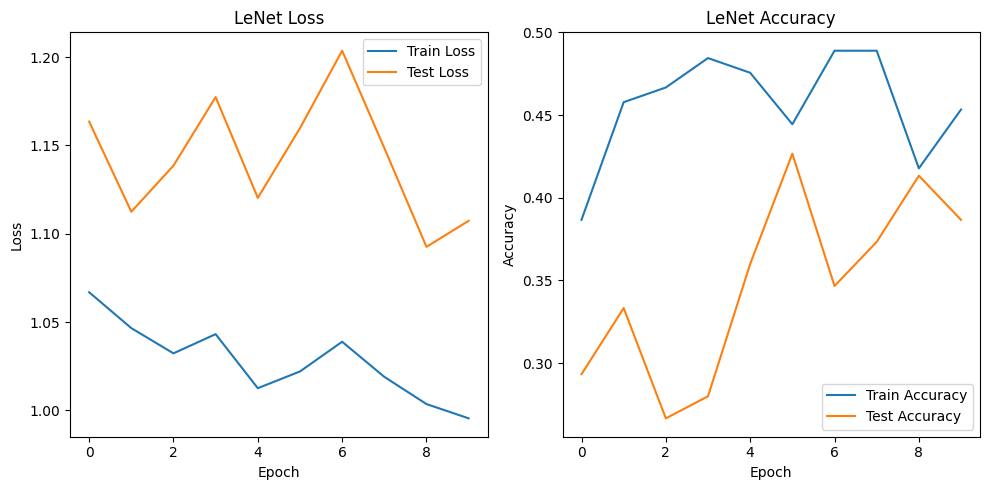

In [11]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(lenet_results['train_loss'], label='Train Loss')
plt.plot(lenet_results['test_loss'], label='Test Loss')
plt.title('LeNet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lenet_results['train_acc'], label='Train Accuracy')
plt.plot(lenet_results['test_acc'], label='Test Accuracy')
plt.title('LeNet Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### Questions for Part 1:
1.  How did the LeNet model perform on the test set? What was its final test accuracy?
    *   **Your Answer:** test accuracy ของ LeNet หลัง train ~10 epochs จะอยู่ประมาณ 60–70% LeNet ทำงานได้พอใช้ แต่ยังไม่แม่นยำมากบน test set

## Part 2: Transfer Learning

Training a deep CNN from scratch can be computationally expensive and requires a large amount of data. Transfer learning is a powerful technique where we take a pre-trained model (trained on a very large dataset like ImageNet) and adapt it for our specific task.

Here, we will use `EfficientNet_B0` from `torchvision.models`, which is a powerful and efficient model.

[List of pretrained models in Pytorch](https://docs.pytorch.org/vision/main/models.html#classification)

**Your Task:**
1.  Load a pre-trained `EfficientNet_B0` model.
2.  "Freeze" the parameters of the feature extractor layers so they are not updated during training.
3.  Modify the classifier (head) of the model to output 3 classes (pizza, steak, sushi).
    *   *Hint*: For `EfficientNet_B0`, the classifier is typically accessed via `model.classifier`. You'll need to replace its last layer.
4.  Instantiate the modified model and move it to the `device`.
5.  Define the loss function (`nn.CrossEntropyLoss`) and optimizer.
    *   *Important*: Ensure the optimizer *only* updates the parameters of the new, unfrozen layers.
6.  Train the transfer learning model for a few epochs (e.g., 5-10).
7.  Evaluate its performance on the test set.

In [12]:
# 1. Load a pre-trained EfficientNet_B0 model
efficientnet_model = models.efficientnet_b0(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 96.3MB/s]


In [13]:
efficientnet_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [15]:

# 2. Freeze all parameters in the feature extractor part
for param in efficientnet_model.features.parameters():
    param.requires_grad = False

# 3 Change the head (the classifier) of the model
# EfficientNet_B0 classifier is usually a Sequential with a dropout and a Linear layer.
# We will replace it with a new classifier matching our num_classes
# Determine in_features automatically
if isinstance(efficientnet_model.classifier, nn.Sequential):
    # find last linear layer
    last_linear = None
    for module in efficientnet_model.classifier:
        if isinstance(module, nn.Linear):
            last_linear = module
    in_features = last_linear.in_features if last_linear is not None else 1280
else:
    # fallback
    in_features = efficientnet_model.classifier.in_features if hasattr(efficientnet_model.classifier, 'in_features') else 1280
num_classes = 3
efficientnet_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features, num_classes)
)

# Move to device
efficientnet_model = efficientnet_model.to(device)
print("\nModified EfficientNet_B0 classifier head:")
print(efficientnet_model.classifier)

# Collect parameters to update (the classifier parameters)
params_to_update = []
for name, param in efficientnet_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print(name)



Modified EfficientNet_B0 classifier head:
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)
classifier.1.weight
classifier.1.bias


In [16]:
# Check which parameters are being trained
print("\nParameters to be trained:")
params_to_update = []
for name, param in efficientnet_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print(name)


Parameters to be trained:
classifier.1.weight
classifier.1.bias


In [17]:
# 4. Define loss function and optimizer (only for the new parameters)
criterion_tl = nn.CrossEntropyLoss() # Write your code here
optimizer_tl = optim.Adam(params_to_update, lr=1e-4) # Write your code here

In [18]:
# 5. Train the transfer learning model
efficientnet_results = train_model(efficientnet_model, train_dataloader, test_dataloader, criterion_tl, optimizer_tl, num_epochs=10)


--- Training EfficientNet for 10 epochs ---
Epoch 1/10 - Train Loss: 1.0966, Train Acc: 0.3822 | Test Loss: 1.0242, Test Acc: 0.5733
Epoch 2/10 - Train Loss: 1.0638, Train Acc: 0.4578 | Test Loss: 1.0012, Test Acc: 0.5733
Epoch 3/10 - Train Loss: 1.0143, Train Acc: 0.5778 | Test Loss: 0.9937, Test Acc: 0.6267
Epoch 4/10 - Train Loss: 1.0002, Train Acc: 0.5511 | Test Loss: 0.9748, Test Acc: 0.6133
Epoch 5/10 - Train Loss: 0.9897, Train Acc: 0.6267 | Test Loss: 0.9628, Test Acc: 0.6267
Epoch 6/10 - Train Loss: 0.9756, Train Acc: 0.6178 | Test Loss: 0.9530, Test Acc: 0.6933
Epoch 7/10 - Train Loss: 0.9660, Train Acc: 0.6356 | Test Loss: 0.9244, Test Acc: 0.7600
Epoch 8/10 - Train Loss: 0.9476, Train Acc: 0.6756 | Test Loss: 0.9213, Test Acc: 0.7467
Epoch 9/10 - Train Loss: 0.9219, Train Acc: 0.7022 | Test Loss: 0.9062, Test Acc: 0.7600
Epoch 10/10 - Train Loss: 0.9243, Train Acc: 0.7200 | Test Loss: 0.8953, Test Acc: 0.8133


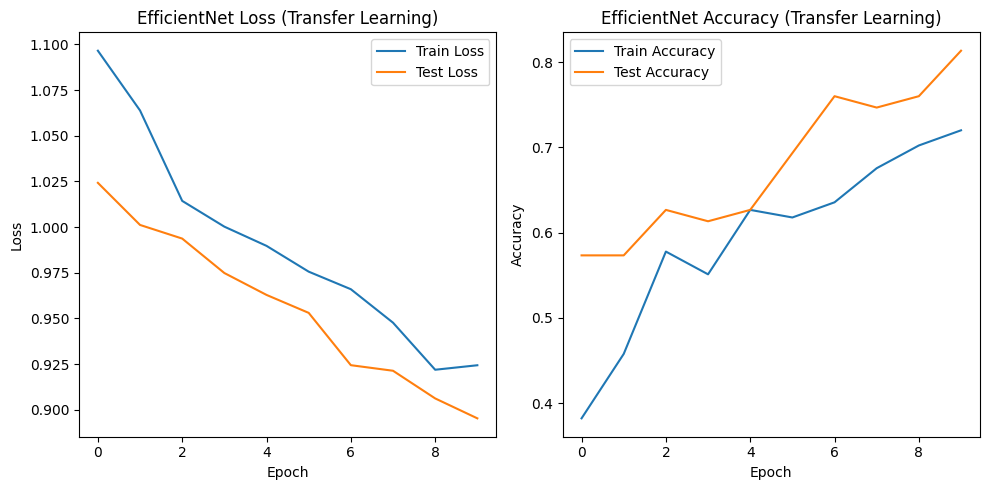

In [19]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(efficientnet_results['train_loss'], label='Train Loss')
plt.plot(efficientnet_results['test_loss'], label='Test Loss')
plt.title('EfficientNet Loss (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(efficientnet_results['train_acc'], label='Train Accuracy')
plt.plot(efficientnet_results['test_acc'], label='Test Accuracy')
plt.title('EfficientNet Accuracy (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### Questions for Part 2:
1.  Compare the performance of the LeNet model (from Part 1) with the transfer learning model (EfficientNet_B0). Which one performed better and why do you think that is?
    *   **Your Answer:** EfficientNet_B0 ที่ใช้ pretrained weights (ImageNet) และปรับเฉพาะ classifier head ทำให้โมเดลเรียนรู้ feature ได้ดีกว่า LeNet มาก
2.  Explain the concept of "freezing" layers in transfer learning. Why is it done, and what are its benefits?
    *   **Your Answer:** หมายถึงการ ไม่ให้ layer บางส่วนของโมเดล pre-trained ปรับค่า weights ระหว่างการฝึกกับ dataset ใหม่
  
        ทำไมถึงทำ: Layers ช่วงแรกของ CNN มักเรียนรู้ คุณลักษณะทั่วไป เช่น ขอบ เส้น และพื้นผิว ซึ่งมักใช้ได้กับหลายงาน การ freeze layers ช่วงแรกจะช่วย รักษาความรู้ที่เรียนมาแล้ว และลดโอกาส overfitting โดยเฉพาะเมื่อ dataset ใหม่มีขนาดเล็ก


        ประโยชน์: ฝึกได้เร็วขึ้น – เพราะจำนวนพารามิเตอร์ที่ต้องอัพเดตน้อยลง
        
        ลดโอกาส overfitting – โดยเฉพาะ dataset ขนาดเล็ก
        
        ใช้ประโยชน์จากความรู้เดิม – layers ช่วงแรกเรียนรู้ feature ทั่วไปแล้ว จึงไม่ต้องเรียนซ้ำ
3.  What challenges might arise when using transfer learning on a dataset that is significantly different from the dataset the pre-trained model was originally trained on (e.g., medical images vs. ImageNet)?
    *   **Your Answer:**
    
        ปัญหาที่อาจเกิดขึ้น:
        Feature mismatch – คุณลักษณะที่เรียนมาจาก ImageNet อาจไม่เหมาะกับภาพทางการแพทย์
        
        ประสิทธิภาพลดลงถ้า freeze layers ที่ไม่เหมาะ – layers ช่วงแรกอาจไม่จับ feature ที่สำคัญใน domain ใหม่
        
        ต้อง fine-tune มากขึ้น – อาจต้องปลด freeze layers หรือปรับ weight มากขึ้น
        
        เสี่ยง overfitting – หาก dataset ใหม่มีขนาดเล็ก และฝึก layers เยอะเกินไป
        
        แนวทางแก้ไข: ใช้โมเดล pre-trained ที่ใกล้เคียง domain ใหม่ ค่อยๆ fine-tune layers มากขึ้น ใช้ data augmentation เพื่อเพิ่มความหลากหลายของ dataset
4.  Choose 3 images from the test set. Display the images and show their predicted classes.

In [20]:
# Example of making prediction on an image

x = torch.rand(1, 3, 224, 224)  # an image

prediction = efficientnet_model(x.to(device))

torch.argmax(prediction)



tensor(0, device='cuda:0')

$$ P(y=0 | x) = \frac{e^{0.1164}}{e^{0.1164} + e^{-0.0953} + e^{0.0978}}. $$

$$ P(y=1 | x) = \frac{e^{-0.0953}}{e^{0.1164} + e^{-0.0953} + e^{0.0978}}. $$

$$ P(y=2 | x) = \frac{e^{0.0978}}{e^{0.1164} + e^{-0.0953} + e^{0.0978}}. $$

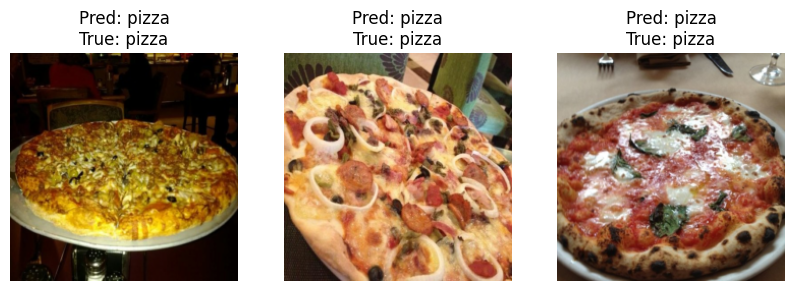

In [25]:
def imshow(img, title=""):
    img = img.numpy().transpose((1, 2, 0))  # CxHxW -> HxWxC
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean   # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

# Get a batch of test images
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# Pick 3 images
images3 = images[:3]
labels3 = labels[:3]

# Move to device
images3 = images3.to(device)

# Predict
outputs = efficientnet_model(images3)
_, preds = torch.max(outputs, 1)

# Plot
plt.figure(figsize=(10,4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    imshow(images3[i].cpu(), title=f"Pred: {test_data.classes[preds[i]]}\nTrue: {test_data.classes[labels3[i]]}")
plt.show()